# Load libraries and model

In [120]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import sys
import glob
import numpy as np
import pandas as pd
import miner as miner
from scipy.stats import zscore
import miner_py3_kk as miner
from tqdm.notebook import tqdm, trange
import time
import matplotlib.pyplot as plt

# change the working directory
os.chdir('/Users/serdarturkaslan/Documents/GitHub/GbmMINER/data/MINER_MicroLowessRNATMM.08.24.2020/')

# Path to the miner directory
input_path = os.getcwd()
print(input_path)

# Load regulon Modules
regulonModules = miner.read_json(os.path.join(input_path,"regulons.json"))
regulonDfMicroGbmLatest = pd.read_csv("regulonDfGbmMicroRNASigCoxAndStatSig.csv", header = 0)
regulonDfMicroGbmLatest = list(regulonDfMicroGbmLatest['Regulon_ID'].drop_duplicates())
regulonDfMicroGbmLatest = [str(i) for i in regulonDfMicroGbmLatest]
regulonModules = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)

# create regulon dictionary
referenceDictionary = regulonModules
print()
print("Loaded " + str(len(referenceDictionary)) + " Regulons.")

/Users/serdarturkaslan/Documents/GitHub/GbmMINER/data/MINER_MicroLowessRNATMM.08.24.2020

Loaded 505 Regulons.


# Load data folders


In [121]:
# Folders for patient data
patientExpFiles = glob.glob('/Volumes/omics4tb2/SYGNAL/Swedish/results/RSEM_results/*')
#patientDataFolders = list(filter(lambda x:'TL-' in x, patientDataFolders))
print('Total Patients to process: %s' %(len(patientExpFiles)))

Total Patients to process: 35


# Load Protein coding genes for filtering

In [122]:
# load protein coding genes list from ensembl for filtering
ensemblProteinCodingGenes = pd.read_csv(os.path.join(input_path,"homo_sapiens_protein_coding_export.txt"), sep="\t", index_col=None, header = 0)
print("Protein Coding Genes")
print(ensemblProteinCodingGenes)

uniqueProteins = list(ensemblProteinCodingGenes['Gene stable ID'].drop_duplicates())
print()
print("Final list has total of " + str(len(uniqueProteins)) + " protein coding genes." )

Protein Coding Genes
         Gene stable ID Transcript stable ID Gene name       Gene type  \
0       ENSG00000284967      ENST00000647178     FDFT1  protein_coding   
1       ENSG00000284967      ENST00000647069     FDFT1  protein_coding   
2       ENSG00000079459      ENST00000538689     FDFT1  protein_coding   
3       ENSG00000079459      ENST00000615631     FDFT1  protein_coding   
4       ENSG00000079459      ENST00000618539     FDFT1  protein_coding   
...                 ...                  ...       ...             ...   
251334  ENSG00000189171      ENST00000440685   S100A13  protein_coding   
251335  ENSG00000189171      ENST00000476133   S100A13  protein_coding   
251336  ENSG00000189171      ENST00000339556   S100A13  protein_coding   
251337  ENSG00000189171      ENST00000392622   S100A13  protein_coding   
251338  ENSG00000189171      ENST00000392623   S100A13  protein_coding   

       Gene Synonym  
0              DGPT  
1              DGPT  
2              DGPT  
3 

# Loop through each patient to calculate regulon activity

In [123]:
# Patient analysis loop
allSummary = pd.DataFrame()
for expFile in tqdm(patientExpFiles):
    time.sleep(0.01)
    patientID = expFile.split('/')[-1] #get patientID
    patientID = patientID.split('.genes.results')[0]
    print("Processed: " + patientID)
    #patientDataFile = os.path.join(folder,"RNA",patientID + ".genes.results") # get RNASeq results
    
    # Check if patient data file exists
    if os.path.exists('%s' %(expFile)):
        # create a new column with patient name
        newColName = patientID + "_zscore"
        
        # Read expression data
        rawExpressionData = pd.read_csv(expFile, sep="\t", index_col=None, header = 0)
        
        
        # seperate ensembl gene ids and symbols
        rawExpressionData[['GeneID','gene_symbol']] = pd.DataFrame(rawExpressionData).gene_id.str.split("_",expand=True)
        #print(rawExpressionData)
        
        # filter for protein coding genes
        rawExpressionDataFilt = rawExpressionData[rawExpressionData.GeneID.isin(uniqueProteins)].copy()
        #rawExpressionDataFilt = rawExpressionData.loc[rawExpressionData.GeneID in uniqueProteins]

        #print("Filtered raw expression")
        #print(rawExpressionDataFilt)
        
        # zscore patients expression data
        rawExpressionDataFilt[[newColName]] = rawExpressionDataFilt[['TPM']].apply(zscore)
   
        #expressionData = pd.read_csv("abundanceXCuresRNATPMTL1961DB85ZScoredLatest.csv", sep=",", index_col=0, header = 0)
        expressionData = rawExpressionDataFilt[[patientID + "_zscore"]]
        expressionData.index = rawExpressionDataFilt['GeneID']
        #print(expressionData)
        
        #print("Processed: " + expFile)
        
        # calculate regulon activity
        rr = miner.generateRegulonActivity(referenceDictionary,expressionData, p=0.05)
        
        # write regulon activity results to file
        rr.to_csv("~/Documents/GitHub/GbmMINER/PD-GSC/Regulon_Activity_" + patientID + ".csv")
   
        # calculate regulon activity stats
        overActiveRegulonCount = len(rr[rr[newColName] == 1])
        underActiveRegulonCount = len(rr[rr[newColName] == -1])
        neutralRegulonCount = len(rr[rr[newColName] == 0])
        
        resSummary = {"Over" : [overActiveRegulonCount],
                              "Under" : [underActiveRegulonCount],
                              "Neutral" : [neutralRegulonCount]}
        resSummary = pd.DataFrame(resSummary)
        resSummary = resSummary.rename(index={0: patientID})
        
        allSummary = allSummary.append(resSummary)
        
    else:
        print("Data file doesnt exist: " + expFile)

print("## Regulon Activity Summary")        
print(allSummary)

  0%|          | 0/35 [00:00<?, ?it/s]

Processed: 01_SN505-Neurosphere-P2
done!
done!
Processed: 36_SN804-Neurosphere-P2
done!
done!
Processed: 14_SN579-Neurosphere-P1
done!
done!
Processed: 15_SN598-Neurosphere-P5
done!
done!
Processed: 13_SN575-Neurosphere-P4
done!
done!
Processed: 16_SN601-Neurosphere-p5
done!
done!
Processed: 37_SN810-Neurosphere-P5
done!
done!
Processed: 39_SN820-Neurosphere-P5
done!
done!
Processed: 05_SN521-Neurosphere-P2
done!
done!
Processed: 04_SN517-Neurosphere-P2
done!
done!
Processed: 03_SN515-Neurosphere-P2
done!
done!
Processed: 06_SN528-Neurosphere-P2
done!
done!
Processed: 07_SN529-Neurosphere-P1
done!
done!
Processed: 02_SN508-Neurosphere-P2
done!
done!
Processed: 12_SN553-Neurosphere-P2
done!
done!
Processed: 10_SN534-Neurosphere-P1
done!
done!
Processed: 08_SN531-Neurosphere-P2
done!
done!
Processed: 17_SN649-Adherent-P5
done!
done!
Processed: 18_SN655-Neurosphere-P3
done!
done!
Processed: 19_SN667-Neurosphere-P2
done!
done!
Processed: 20_SN674-Neurosphere-P2
done!
done!
Processed: 21_SN

# Loop through each patient to calculate Program activity

In [124]:
# Load Transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,"transcriptional_programs.json"))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]


# Create dictionary of program genes
# make dictionary of program keys with gene lists as elements
pr_genes_expanded = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        if r in regulonModules:
            genes.append(regulonModules[r])
    if len(genes) != 0:
        genes = list(set(np.hstack(genes)))
        pr_genes_expanded[i] = genes
#print(regulonModules)        
#print(pr_genes_expanded[1])
        
# Patient analysis loop
allProgSummary = pd.DataFrame()
for expFile in tqdm(patientExpFiles):
    time.sleep(0.01)
    patientID = expFile.split('/')[-1] #get patientID
    patientID = patientID.split('.genes.results')[0]
    print("Processing: " + patientID)
    
    # Check if patient data file exists
    if os.path.exists('%s' %(expFile)):
        # create a new column with patient name
        newColName = patientID + "_zscore"
        
        # Read expression data
        rawExpressionData = pd.read_csv(expFile, sep="\t", index_col=None, header = 0)
        
        
        # seperate ensembl gene ids and symbols
        rawExpressionData[['GeneID','gene_symbol']] = pd.DataFrame(rawExpressionData).gene_id.str.split("_",expand=True)
        #print(rawExpressionData)
        
        # filter for protein coding genes
        rawExpressionDataFilt = rawExpressionData[rawExpressionData.GeneID.isin(uniqueProteins)].copy()
        #rawExpressionDataFilt = rawExpressionData

        #print("Filtered raw expression")
        #print(rawExpressionDataFilt)
        
        # zscore patients expression data
        rawExpressionDataFilt[[newColName]] = rawExpressionDataFilt[['TPM']].apply(zscore)
   
        #expressionData = pd.read_csv("abundanceXCuresRNATPMTL1961DB85ZScoredLatest.csv", sep=",", index_col=0, header = 0)
        expressionData = rawExpressionDataFilt[[patientID + "_zscore"]]
        expressionData.index = rawExpressionDataFilt['GeneID']
        #print(expressionData)
        
        #print("Processed: " + expFile)
           
        # Calculate program activity
        #pp = miner.generateProgramActivity(transcriptional_programs = transcriptional_programs, regulonModules=referenceDictionary, expressionData=expressionData, p=0.05)   
        
        # select reference dictionary for downstream analysis (pr_genes, revisedClusters, coexpressionModules, or regulonModules)
        referenceDictionaryPr = pr_genes_expanded
        
        # create a background matrix used for statistical hypothesis testing
        bkgd = miner.backgroundDf(expressionData)
        #print(bkgd)
        # for each cluster, give samples that show high coherent cluster activity
        overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionaryPr,bkgd,label=2,p=0.05)
        
        # for each clus|ter, give samples that show low coherent cluster activity
        underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionaryPr,bkgd,label=0,p=0.05)
        
        # convert overExpressedMembers dictionary to binary matrix
        overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
        #overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
        #print(overExpressedMembersMatrix)
        # convert underExpressedMembers dictionary to binary matrix
        underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
        #underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
        #print(underExpressedMembersMatrix)
        # Create program matrix with values of {-1,0,1}
        pp = overExpressedMembersMatrix-underExpressedMembersMatrix
        
        ## Histogram plot
        #plt.hist(pp, bins='auto')
        #plt.title("Program activity for " + patientID)
        #plt.show()
        #print(pp)

        # write Program activity results to file
        pp.to_csv("~/Documents/GitHub/GbmMINER/PD-GSC/Program_Activity_" + patientID + ".csv")
        
        # calculate Program activity stats
        overActiveProgramCount = len(pp[pp[newColName] == 1])
        underActiveProgramCount = len(pp[pp[newColName] == -1])
        neutralProgramCount = len(pp[pp[newColName] == 0])
        
        resProgSummary = {
            "Over" : [overActiveProgramCount],
            "Under" : [underActiveProgramCount],
            "Neutral" : [neutralProgramCount]
        }
        
        resProgSummary = pd.DataFrame(resProgSummary)
        resProgSummary = resProgSummary.rename(index={0: patientID})
        
        allProgSummary = allProgSummary.append(resProgSummary)
        
        
    else:
        print("Data file doesnt exist: " + expFile)

print("## Program Activity Summary")
print(allProgSummary)

  0%|          | 0/35 [00:00<?, ?it/s]

Processing: 01_SN505-Neurosphere-P2
done!
done!
Processing: 36_SN804-Neurosphere-P2
done!
done!
Processing: 14_SN579-Neurosphere-P1
done!
done!
Processing: 15_SN598-Neurosphere-P5
done!
done!
Processing: 13_SN575-Neurosphere-P4
done!
done!
Processing: 16_SN601-Neurosphere-p5
done!
done!
Processing: 37_SN810-Neurosphere-P5
done!
done!
Processing: 39_SN820-Neurosphere-P5
done!
done!
Processing: 05_SN521-Neurosphere-P2
done!
done!
Processing: 04_SN517-Neurosphere-P2
done!
done!
Processing: 03_SN515-Neurosphere-P2
done!
done!
Processing: 06_SN528-Neurosphere-P2
done!
done!
Processing: 07_SN529-Neurosphere-P1
done!
done!
Processing: 02_SN508-Neurosphere-P2
done!
done!
Processing: 12_SN553-Neurosphere-P2
done!
done!
Processing: 10_SN534-Neurosphere-P1
done!
done!
Processing: 08_SN531-Neurosphere-P2
done!
done!
Processing: 17_SN649-Adherent-P5
done!
done!
Processing: 18_SN655-Neurosphere-P3
done!
done!
Processing: 19_SN667-Neurosphere-P2
done!
done!
Processing: 20_SN674-Neurosphere-P2
done!
d

(array([ 2.,  0.,  0.,  0., 51.,  0.,  0., 28.]),
 array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ]),
 <BarContainer object of 8 artists>)

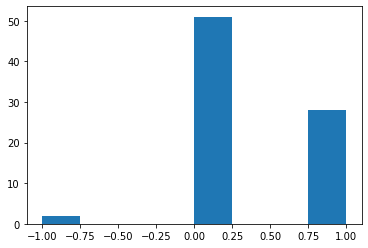

In [97]:
import matplotlib.pyplot as plt
plt.hist(pp, bins='auto')

pl

(array([6547.,    0.,    0.,    0.,    0., 6543.,    0.,    0.,    0.,
        6548.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

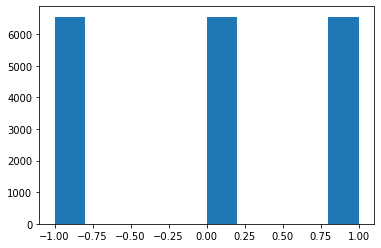

In [106]:
plt.hist(bkgd)